In [ ]:
%pip install gensim==4.2.0 pqkmeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
#Librerías empleadas

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Librerías de procesado
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re
import gc

import ast
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import KeyedVectors

from gensim.models import Word2Vec
from gensim import downloader
from gensim.models import FastText

import torch.nn as nn

from nltk.tokenize import wordpunct_tokenize #Para el tokenizado por palabras
from nltk.stem import WordNetLemmatizer #Para la obtención de los lemmas de los tokens
from nltk.corpus import stopwords #Stopwords para tener en cuenta en la limpieza de los textos

from scipy.sparse import csr_matrix #Para poder manejar sparse matrix y ahorrar memoria
import numpy as np #Librería para procesado numérico
from scipy.sparse import save_npz #Para guardar sparse matrix
from gensim import downloader #Para cargar modelos de Gensim


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**VARIABLES GLOBALES**

A continuación, se describen una serie de variables globales booleanas que se podrán modificar según se quieran realizar algunos pasos o no.

In [2]:
execute_preproc = False #Variable para determinar si se debe realizar el preprocesado de datos o no
load_preproc = not execute_preproc #En el caso de que no se quiera realizar el preprocesado de datos, se cargará directamente el archivo de los proyectos ya preprocesados
execute_w2v = False #Variable para determinar si ejecutar el W2V o no. En caso de no, se cargará automáticamente de Drive el DataFrame con los ya añadidos del W2V
execute_glove = False
execute_FT = True

In [3]:

import warnings
warnings.filterwarnings("ignore")

# Paso 1. Preprocesado de textos

En este primer paso se procede a usar un pipeline de pre-procesado de los textos obtenidos

## Extracción de los datos

El primer paso consistirá en la extracción de los datos obtenidos, así como determinación de los datos útiles para su pre-procesado.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_to_folder = '/content/drive/MyDrive/2º/NLP/Proyecto/'  

In [6]:
df_projects = pd.read_excel(path_to_folder+'projects.xlsx') #Dataframe donde se almacenan los datos de los proyectos
df_projects.head()

,projectID,acronym,title,summary,startDate,endDate,totalCost,ecMaxContribution,masterCall,subCall,fundingScheme,rcn,topic,topic_title,countryContr,coordinatorCountry,euroSciVocCode,publicationID,patentID
0,115843,EbolaMoDRAD,Ebola Virus: Modern Approaches for developing ...,The current Ebola Virus Disease (EVD) outbreak...,2015-02-01,2018-01-31,4300935.00,4300935.00,H2020-JTI-IMI2-2014-02-single-stage,H2020-JTI-IMI2-2014-02-single-stage,IMI2-RIA,209451,IMI2-2014-02-05,Rapid diagnostic tests,BE|318125.0 DE|175000.0 DK|520875.0 FI|261250....,SE,"[155, 56306972, 325, 137, 1609]","['115843_202840_PUBLI', '115843_202838_PUBLI',...",NaN
1,115910,PERISCOPE,PERtussIS COrrelates of Protection Europe - So...,Pertussis vaccines have been very successful i...,2016-03-01,2022-08-31,29926687.00,21000000.00,H2020-JTI-IMI2-2015-03-two-stage,H2020-JTI-IMI2-2015-03-two-stage,IMI2-RIA,209454,IMI2-2015-03-05,Pertussis vaccination research,BE|475092.0 CH|0.0 CZ|300000.0 DE|581250.0 ES|...,NL,"[137, 1439, 44109686, 48479582]","['115910_1008742_PUBLI', '115910_629396_PUBLI'...",NaN
2,635266,TRACE,Opening the cycling and walking tracking poten...,This project will explore the potential of wal...,2015-06-01,2018-05-31,2896984.75,2896984.75,NaN,H2020-MG-2014_TwoStages,RIA,193324,MG-5.3-2014,Tackling urban road congestion,BE|728066.0 BG|117720.0 IT|157362.5 LU|301162....,PT,[1373],['635266_251009_PUBLI'],NaN
3,637488,MotMotLearn,"Motivating Motor Learning: The Role of Reward,...",Motor learning (the ability of the brain to le...,2015-10-01,2021-03-31,1497885.00,1497885.00,ERC-2014-STG,ERC-2014-STG,ERC-STG,198591,ERC-StG-2014,ERC Starting Grant,UK|1497885.0,UK,"[159, 227, 337, 635]","['637488_666976_PUBLI', '637488_153804_PUBLI',...",NaN
4,639226,MAMI,The Power of Maternal Microbes on Infant Health,Recent reports suggest that early microbial co...,2015-06-01,2020-12-31,1499979.00,1499979.00,ERC-2014-STG,ERC-2014-STG,ERC-STG,193636,ERC-StG-2014,ERC Starting Grant,ES|1499979.0,ES,"[155, 137, 38005658, 1461, 183]","['639226_959337_PUBLI', '639226_24903_PUBLI', ...",NaN


En base a los datos anteriores, podemos realizar las siguientes conclusiones :    
-  En primer lugar, para el procesado de textos, se va a hacer uso de la unión del `title y summary` de cada uno de los proyectos.
-  En segundo lugar, el resto de variables van a ser empleados como parámetros para los modelos de clasificación.
-  En tercer lugar, la variable `euroSciVocCode``contiene el código de la community a la que pertenece cada documento. Esto resultará importante para la  clasificación en comunidades que se realizará posteriormente.

Tras esto, procedemos a unir las columnas `title y summary` en una sola.

In [7]:
df_projects['text'] = df_projects['title'] + "." + df_projects['summary'] #Se concatenan ambas columnas en una columna llamada 'text'
df_projects.drop(axis=1, columns=['title','summary'], inplace=True) #Se eliminan las columnas de titl y summary para ahorrar espacio en memoria+
print(df_projects.head())

   projectID      acronym  startDate    endDate    totalCost  \
0     115843  EbolaMoDRAD 2015-02-01 2018-01-31   4300935.00   
1     115910    PERISCOPE 2016-03-01 2022-08-31  29926687.00   
2     635266        TRACE 2015-06-01 2018-05-31   2896984.75   
3     637488  MotMotLearn 2015-10-01 2021-03-31   1497885.00   
4     639226         MAMI 2015-06-01 2020-12-31   1499979.00   

   ecMaxContribution                           masterCall  \
0         4300935.00  H2020-JTI-IMI2-2014-02-single-stage   
1        21000000.00     H2020-JTI-IMI2-2015-03-two-stage   
2         2896984.75                                  NaN   
3         1497885.00                         ERC-2014-STG   
4         1499979.00                         ERC-2014-STG   

                               subCall fundingScheme     rcn            topic  \
0  H2020-JTI-IMI2-2014-02-single-stage      IMI2-RIA  209451  IMI2-2014-02-05   
1     H2020-JTI-IMI2-2015-03-two-stage      IMI2-RIA  209454  IMI2-2015-03-05   
2    

## Preprocesado de los datos

Tras haber obtenido el texto final para cada uno de los proyectos, se procede a realizar un procesado del texto sobre la columna `text`. Para ello, se implementa la función `prepare_text`. En dicha función se realizan los siguientes pasos :    

-  Text Wrangling : Consiste en realizar una primera limpieza de posibles tags derivados del HTML, así como expandir las contracciones del habla inglesa, ya que se observa que los textos de los proyectos están escritos en inglés.
-  Tokenization : Consiste en segmentar el texto de cada proyecto en una lista de tokens. Es decir, se separa el texto en una lista con cada una de las palabras que lo componen.
-  Homogenization : Consiste en reducir la lista obtenida en el paso anterior, de manera que los tokens que tengan un mismo significado semántico sean agrupados en un sólo token. En concreto, para el caso de este proyecto, y ya que se ha demostrado que su funcionamiento suele ser mejor, se optará por reducir los tokens a través de sus lemas.
-  Cleaning : El último paso del preprocesado se corresponde a la realización de una limpieza final de los lemas obtenidos. Para ello, se eliminarán aquellos lemas que :    
  -  Sean extraños, es decir, apenas aparezcan en el conjunto global de los textos.
  -  Aquellos lemas que sean muy comunes en todos los componentes del corpus y que por lo tanto no aporten ninguna información diferencial en los documentos.


In [8]:
def prepare_text(text):
  #Función que ejecuta todos los pasos necesarios para el preprocesado del texto
  '''
  Primer paso : Text wrangling
  Este primer paso consiste en eliminar todos los términos extraños del texto. Es decir:
    -Eliminar tags derivados del HTML.
    -Eliminar direcciones http
    -Eliminar contracciones propias del inglés.
  '''
  text = BeautifulSoup(text, 'lxml').get_text() #Se eliminan los tags de HTML
  text = re.sub(r'http\S+', '', text, flags=re.MULTILINE) #Se eliminan todos aquellos términos que empieces por http, es decir, las direcciones webs adjuntas
  text = contractions.fix(text) #Se reajustan las contracciones propias del inglés
  '''
  Segundo paso : Tokenization
  Este segundo paso consiste en extraer los términos propios del texto. Para ello, se puede realizar mediante : 
    -Extracción de las palabras presentes en el texto.
    -Extracción de las frases presentes en el texto.
  '''
  project_tokens = wordpunct_tokenize(text) #Se tokeniza la descripción del proyecto por palabras
  '''
  Tercer paso : Homogenization
  Este tercer paso consiste en extraer los lemas presentes en el diccionario de palabras que nos ha quedado tras realizar la tokenización. Para ello, se han de realizar los siguientes pasos : 
    -Convertir todas las palabras tokenizadas en minúsculas.
    -Extraer los lemas de cada una de las palabras. Para ello, sólo se puede trabajar con palabras que contengan carácteres alfanuméricos.
  '''
  project_tokens_filtered_lower = [x.lower() for x in project_tokens] #Se convierten en minúscula todas las palabras tokenizadas de la primera project
  project_tokens_filtered = [x for x in project_tokens_filtered_lower if x.isalnum()] #Se toman aquellos tokens que sólo contengan carácteres alfanuméricos
  wnl = WordNetLemmatizer()
  lemmatized_project = [wnl.lemmatize(el) for el in project_tokens_filtered]
  '''
  Cuarto paso : Cleaning
  Este último paso consiste en eliminar los lemas que se correspondan con stopwords.
  Los stopwords son palabras que no tienen un contenido semántico elevado, como pronombres, determinantes...
  '''
  stopwords_en = stopwords.words('english')
  clean_project = [lemma for lemma in lemmatized_project if lemma not in stopwords_en]
  return clean_project

Finalmente, se aplica dicha función sobre cada uno de los textos del DataFrame de los proyectos.

In [9]:
if execute_preproc : 
  clean_text = df_projects['text'].apply(prepare_text)
  df_projects['clean_text'] = clean_text
  print(df_projects.head())

**NOTA** : Dado que la ejecución de la celda anterior tarda algo de tiempo, se guarda el DataFrame obtenido tras el filtrado para el caso en el que se desee no realizar todo el preprocesado anterior y se prefiere realizar los siguientes pasos directamente.

In [10]:
if execute_preproc:
  df_projects.to_excel("projects_preprocessed.xlsx")

# Paso 2. Representación vectorial

En este apartado, se procede a obtener la representación vectorial para cada uno de los proyectos, realizándolo de tres maneras diferentes.

In [11]:
name_file_preproc = 'projects_preprocessed.xlsx' #Nombre del archivo con el texto de los proyectos ya preprocesado
if load_preproc:
  #En el caso de que se decida cargar directamente el archivo de preprocesado
  df_projects_preprocessed = pd.read_excel(path_to_folder+name_file_preproc) #Dataframe donde se almacenan los datos de los proyectos ya preprocesados
else : 
  df_projects_preprocessed = df_projects.copy()

Utilizad esto si usais el dataset de Alejandro, si usais el de José no hace falta:

In [12]:
for i in range(df_projects_preprocessed.shape[0]):
    df_projects_preprocessed['clean_text'][i] = ast.literal_eval(df_projects_preprocessed['clean_text'][i])

Tras la selección del DataFrame ya preprocesado anterior, se procede a eliminar aquellos tokens que :    

-  Aparezcan con una frecuencia muy baja en los documentos, ya que resultan muy extraños.
-  Aparezcan en la gran mayoría de documentos, ya que no aportan ninguna información extra que los diferencie.

Primero obtenemos el corpus de nuestro colección de documentos:

In [13]:
corpus = []

for i in range (df_projects_preprocessed.shape[0]):
    corpus.append(df_projects_preprocessed['clean_text'].values[i])

print('Cantidad de documentos en el corpus: '+str(len(corpus)))
print('\n============= Ejemplo del primer documento =============')
print(corpus[0])

Cantidad de documentos en el corpus: 35378

============= Ejemplo del primer documento =============
['ebola', 'virus', 'modern', 'approach', 'developing', 'bedside', 'rapid', 'diagnostics', 'sofia', 'ref', '115843', 'current', 'ebola', 'virus', 'disease', 'evd', 'outbreak', 'ha', 'caused', '5000', 'death', 'within', 'month', 'west', 'africa', 'guinea', 'sierra', 'leone', 'liberia', 'severely', 'affected', 'country', 'including', 'numerous', 'healthcare', 'worker', 'serious', 'public', 'health', 'crisis', 'international', 'concern', 'number', 'case', 'still', 'increasing', '11', 'month', 'first', 'case', 'wa', 'described', 'december', '2013', 'mid', 'november', '2014', 'approximately', '15000', 'individual', 'infected', 'epidemic', 'still', 'control', 'direct', 'effect', 'outbreak', 'include', 'disruption', 'standard', 'medical', 'care', 'insecurity', 'social', 'disruption', 'country', 'already', 'struggling', 'recover', 'decade', 'war', 'one', 'important', 'key', 'action', 'limit', 's

Establecemos los n_gramas

In [14]:
phrase_model = Phrases(corpus, min_count=4, threshold=20)

print('\n============= Primer doc del corpus =============')
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print('\n============= Primer doc del corpus tras establecer los N-gramas =============')
print(corpus[0])


============= Primer doc del corpus =============
['ebola', 'virus', 'modern', 'approach', 'developing', 'bedside', 'rapid', 'diagnostics', 'sofia', 'ref', '115843', 'current', 'ebola', 'virus', 'disease', 'evd', 'outbreak', 'ha', 'caused', '5000', 'death', 'within', 'month', 'west', 'africa', 'guinea', 'sierra', 'leone', 'liberia', 'severely', 'affected', 'country', 'including', 'numerous', 'healthcare', 'worker', 'serious', 'public', 'health', 'crisis', 'international', 'concern', 'number', 'case', 'still', 'increasing', '11', 'month', 'first', 'case', 'wa', 'described', 'december', '2013', 'mid', 'november', '2014', 'approximately', '15000', 'individual', 'infected', 'epidemic', 'still', 'control', 'direct', 'effect', 'outbreak', 'include', 'disruption', 'standard', 'medical', 'care', 'insecurity', 'social', 'disruption', 'country', 'already', 'struggling', 'recover', 'decade', 'war', 'one', 'important', 'key', 'action', 'limit', 'stop', 'spread', 'deadly', 'disease', 'identify', '

Generamos el diccionario de nuestro corpus

In [15]:
D = Dictionary(corpus)
n_tokens = len(D)

print('El diccionario contiene', n_tokens, 'tokens')

El diccionario contiene 140443 tokens


Eliminamos toda palabra del diccionario que aparezca muy pocas veces o demasiadas (ya que carecen de valor semántico para los modelos)

In [16]:
no_below = 6 
no_above = .80 

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('El diccionario contiene', n_tokens, 'tokens')

El diccionario contiene 37206 tokens


## BoW

In [18]:
text_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 0

print('\n============= Representación BoW del doc 0 =============')
print(text_bow[n_review])


============= Representación BoW del doc 0 =============
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 3), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 3), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 4), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 4), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 5), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 2), (104, 1), (

## TFIDF

In [19]:
tfidf = TfidfModel(text_bow)

In [20]:
reviews_tfidf = tfidf[text_bow]
n_review = 0

print('\n============= Representación TFIDF del doc 0 =============')
print(reviews_tfidf[n_review])


============= Representación TFIDF del doc 0 =============
[(0, 0.05874017797595176), (1, 0.0588188691178983), (2, 0.08920950825203651), (3, 0.032679587099265335), (4, 0.06687676761268009), (5, 0.07335455172248394), (6, 0.04141752581300412), (7, 0.01603823681914833), (8, 0.06794455763527826), (9, 0.02737370226354945), (10, 0.033275036510516026), (11, 0.09584504997844186), (12, 0.09915924467600361), (13, 0.05115073417967314), (14, 0.0745148340901541), (15, 0.05366130707236205), (16, 0.109844525677824), (17, 0.043086924927717526), (18, 0.0782811858158168), (19, 0.04882736708528774), (20, 0.03708890417926799), (21, 0.049746829045667594), (22, 0.05658644516952411), (23, 0.05398169772860683), (24, 0.05582251527307547), (25, 0.07807192668257516), (26, 0.06892808629475744), (27, 0.060975693982121174), (28, 0.04526956076770933), (29, 0.06720058418695969), (30, 0.032545694212315235), (31, 0.11200573387853742), (32, 0.05342657999088056), (33, 0.056166584114702045), (34, 0.12172372780893226), (3

## Modelos de Word Embeddings

Entrenamos los modelos de Word Embedding con el corpus de nuestro dataset

### Word2Vec

In [ ]:
if execute_w2v:
  model_w2v = Word2Vec(corpus, vector_size=200, window=5, min_count=1, seed=42, sg=1)
  words = list(model_w2v.wv.key_to_index) #Diccionario con las palabras presentes en el corpus y su ID asociado
  

Ha tardado 6 min en ejecutarse

Se procede a guardar el modelo para un caso futuro de uso en el que queramos realizar las comparaciones directamente, y por tanto ya carguemos el modelo con el corpus ya procesado.

In [ ]:
if execute_w2v:
  model_w2v.save("model_w2v_project.model")

In [ ]:
if execute_w2v:
  # Store just the words + their trained embeddings.
  word_vectors = model_w2v.wv #Se crea una variable que contiene los vectores de palabras, con diccionario que son clave-palabra valor-vector.
  word_vectors.save("model_w2v_project.wordvectors") #Se guarda la variable anterior con el nombre introducido

  # Load back with memory-mapping = read-only, shared across processes.
  wv = KeyedVectors.load("model_w2v_project.wordvectors", mmap='r') #Para no guardar el modelo completo, sólo nos quedamos con el diccionario anterior
  del model_w2v #Eliminamos el modelo W2V para ahorrar espacio en memoria
  gc.collect()

Tras ello, se procede a crear una función que genere el vector de un documento a través de los vectores extraídos con el W2V. El valor de dicho vector será la media de todos los vectores de los tokens presentes en el documento que se encuentren almacenados en el diccionario W2V.

In [ ]:
def get_review_vector(model, review):
  # <SOL>
  # TODO: Implement body

  words = list(model.key_to_index) #Se obtiene la lista de las palabras del modelo
  cleand_review = [wd for wd in review if wd in words] #Se extrae una lista de palabras del modelo presentes en la review actual
  #cleand_review = [wd for wd in review]
  vec = model.get_mean_vector(cleand_review) #De la lista de palabras presentes en la review, se extrae la media de sus vectores asociados
  '''
  if not (word in fastText_wv.key_to_index):
    print(f'The word {word} does not belong to the dictionary. The embedding constructed from the subwords is:\n')
    print(fastText_wv[word])
    print('\nAnd its closest neighbors are:')
    print(fastText_wv.most_similar(word))
  '''
  return vec

Finalmente, se obtiene la representación vectorial por cada uno de los documentos.


In [ ]:
if execute_w2v:
  # TODO: Calculate embedding vectors for each review and save them in a sparse matrix
  vectors_w2v = []
  for review in corpus:
    vectors_w2v.append(get_review_vector(model=wv, review=review))
  # </SOL>
  sparse_matrix_w2v = csr_matrix(vectors_w2v) #Representación en una sparse matrix de los vectores W2V asociados a los documentos 

Ha tardado unos 15 min en ejecutarse

Debido a que el conjunto de paso anteriores asociados a W2V tardan un cierto tiempo en ejecutarse, se procede a guardar todas las variables que vayan a ser necesarias tener, sin tener que volver a calcularlas de nuevo.

In [ ]:
from scipy.sparse import save_npz

if execute_w2v:
  save_npz('sparse_matrix_w2v.npz', sparse_matrix_w2v) #Guardado de la sparse matrix
  del sparse_matrix_w2v #Se borra la matriz anterior para ahorrar memoria
  gc.collect()
  df_projects_preprocessed_embeddings = df_projects_preprocessed.copy() #Se crea una copia del DataFrame preprocesado
  df_projects_preprocessed_embeddings['w2v'] = pd.Series(vectors_w2v) #Se añaden los arrays obtenidos con W2V
  df_projects_preprocessed_embeddings.to_excel("df_projects_preprocessed_embeddings.xlsx")
  df_projects_preprocessed_embeddings.head()
else:
  #En el caso de que se haya decidido cargar directamente los modelos de W2V
  name_file_embeddings = 'df_projects_preprocessed_embeddings.xlsx' #Nombre del archivo con el texto de los proyectos ya preprocesado
  df_projects_preprocessed_embeddings = pd.read_excel(path_to_folder+name_file_embeddings) #Dataframe donde se almacenan los datos de los proyectos ya preprocesados



### GloVe

En primer lugar, se procede a descargar un diccionario de Glove

In [ ]:
glove_dict = downloader.load('glove-wiki-gigaword-50')

In [ ]:
print(f"The dictionary size is {glove_dict.vectors.shape[0]}.\n\
        Each embedding has a dimension of {glove_dict.vectors.shape[1]}")

The dictionary size is 400000.
        Each embedding has a dimension of 50


Se obtienen los vectores de cada uno de los documentos, a través de Glove.

In [ ]:
if execute_glove:
  # <SOL>
  vectors_glove = []
  for review in corpus:
    vectors_glove.append(get_review_vector(model=glove_dict, review=review))

  sparse_matrix_glove = csr_matrix(vectors_glove) #Se obtiene la sparse matrix que represente a los documentos
  # </SOL>

KeyboardInterrupt: ignored

In [ ]:

if execute_glove:
  save_npz('sparse_matrix_glove.npz', sparse_matrix_glove) #Guardado de la sparse matrix
  del sparse_matrix_glove #Se borra la matriz anterior para ahorrar memoria
  gc.collect()
  df_projects_preprocessed_embeddings = df_projects_preprocessed.copy() #Se crea una copia del DataFrame preprocesado
  df_projects_preprocessed_embeddings['glove'] = pd.Series(vectors_glove) #Se añaden los arrays obtenidos con Glove
  df_projects_preprocessed_embeddings.to_excel("df_projects_preprocessed_embeddings.xlsx")
  df_projects_preprocessed_embeddings.head()
else:
  #En el caso de que se haya decidido cargar directamente los modelos de Glove
  name_file_embeddings = 'df_projects_preprocessed_embeddings.xlsx' #Nombre del archivo con el texto de los proyectos ya preprocesado
  df_projects_preprocessed_embeddings = pd.read_excel(path_to_folder+name_file_embeddings) #Dataframe donde se almacenan los datos de los proyectos ya preprocesados



### FastText

In [ ]:
if execute_FT:
  model_fasttext = FastText(corpus,vector_size=200, min_count=10, window=5, seed=42)
  # Save model 
  model_fasttext.save("model_fastText.model")

  # Store just the words + their trained embeddings.
  word_vectors = model_fasttext.wv
  word_vectors.save("model_fastText.wordvectors")

  # Load back with memory-mapping = read-only, shared across processes.
  fastText_wv = KeyedVectors.load("model_fastText.wordvectors", mmap='r')
  del model_fasttext
  gc.collect()

KeyboardInterrupt: ignored

In [ ]:
try:
  import compress_fasttext
except ModuleNotFoundError:
  %pip install compress-fasttext
  import compress_fasttext

In [ ]:
fastTextPre = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/v0.0.4/cc.en.300.compressed.bin'
)

Se reformula la función para obtener los embeddings de los documentos. De esta manera, se busca que se consideren también las OOV, ya que FastText es capaz de procesarlas y asignarles un vector a través de subwords que puedan encontrarse en la palabra que se está procesando.

In [ ]:
def get_review_vector_FT(model, review):
  # <SOL>
  # TODO: Implement body

  words = list(model.key_to_index) #Se obtiene la lista de las palabras del modelo
  vec = 0
  for wd in review:
    vec = vec + model[wd]
  #cleand_review = [wd for wd in review if wd in words] #Se extrae una lista de palabras del modelo presentes en la review actual
  vec = vec/len(review)
  return vec

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
if execute_FT:
  vectors_ft = []
  for review in corpus:
    vectors_ft.append(get_review_vector_FT(model=fastTextPre, review=review)) #Se toma como modelo los embeddings 

  sparse_matrix_ft = csr_matrix(vectors_ft)


Se han truncado las últimas 5000 líneas del flujo de salida.


Ha tardado 15 min

In [ ]:

.
if execute_FT:
  save_npz('sparse_matrix_ft.npz', sparse_matrix_ft) #Guardado de la sparse matrix
  del sparse_matrix_ft #Se borra la matriz anterior para ahorrar memoria
  gc.collect()
  df_projects_preprocessed_embeddings = df_projects_preprocessed.copy() #Se crea una copia del DataFrame preprocesado
  df_projects_preprocessed_embeddings['ft'] = pd.Series(vectors_ft) #Se añaden los arrays obtenidos con Glove
  df_projects_preprocessed_embeddings.to_excel("df_projects_preprocessed_embeddings.xlsx")
  df_projects_preprocessed_embeddings.head()
else:
  #En el caso de que se haya decidido cargar directamente los modelos de Glove
  name_file_embeddings = 'df_projects_preprocessed_embeddings.xlsx' #Nombre del archivo con el texto de los proyectos ya preprocesado
  df_projects_preprocessed_embeddings = pd.read_excel(path_to_folder+name_file_embeddings) #Dataframe donde se almacenan los datos de los proyectos ya preprocesados



### ElMo

## LSI

Generamos un modelo LSI dado nuestro corpus y con 10 topics

In [23]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 10

lsi = LsiModel(corpus = reviews_tfidf, num_topics = n_topics, id2word = D)


Veamos las 15 palabras más destacables (o que más definen) a cada uno de los topics

In [24]:
lsi.show_topics(num_topics=-1, num_words=15, log=False, formatted=True)

[(0,
  '0.102*"system" + 0.099*"research" + 0.099*"data" + 0.096*"energy" + 0.096*"technology" + 0.091*"innovation" + 0.089*"market" + 0.086*"service" + 0.080*"network" + 0.079*"material" + 0.078*"solution" + 0.077*"european" + 0.076*"cell" + 0.076*"process" + 0.074*"new"'),
 (1,
  '-0.269*"cell" + 0.222*"service" + 0.219*"innovation" + 0.188*"smes" + 0.153*"innovation_management" + -0.152*"cancer" + -0.145*"protein" + 0.116*"support" + -0.114*"quantum" + -0.105*"disease" + -0.093*"molecular" + 0.090*"energy" + -0.090*"patient" + -0.089*"brain" + 0.088*"market"'),
 (2,
  '0.207*"quantum" + 0.187*"energy" + -0.169*"innovation" + 0.156*"material" + -0.145*"innovation_management" + -0.135*"smes" + -0.121*"research" + 0.108*"device" + -0.107*"social" + 0.104*"market" + -0.103*"cell" + -0.103*"policy" + -0.100*"service" + 0.099*"technology" + -0.099*"cancer"'),
 (3,
  '-0.394*"quantum" + 0.222*"cell" + 0.196*"cancer" + 0.192*"patient" + 0.136*"treatment" + 0.135*"market" + -0.125*"theory" +

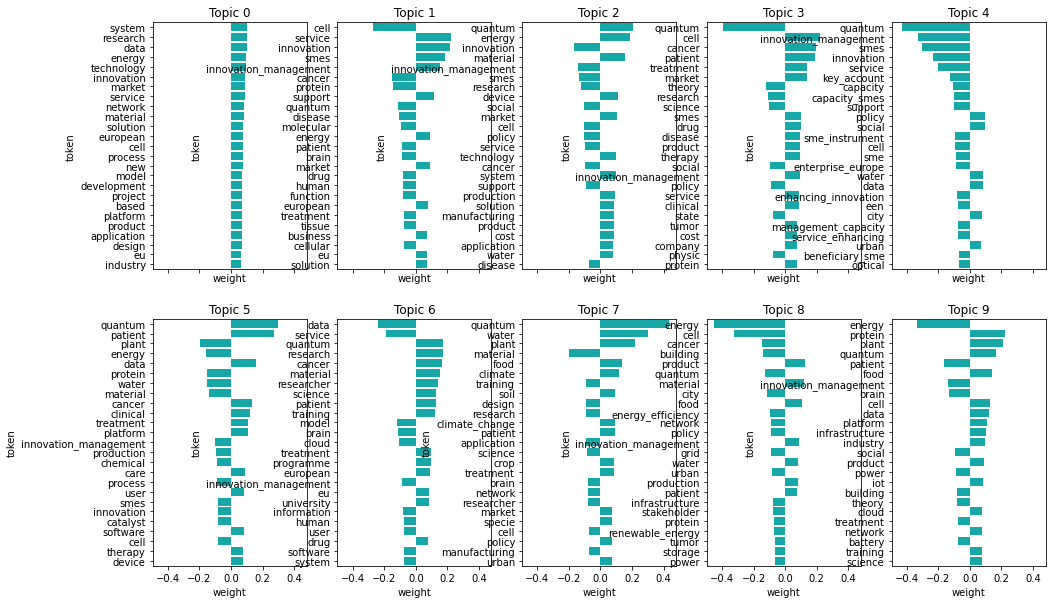

In [29]:
topn = 25

fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):

    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(lsi.show_topic(i,topn = topn), columns = ['token', 'weight'])
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i + 4
    #df = pd.DataFrame( ...
    df = pd.DataFrame(lsi.show_topic(i+5,topn = topn), columns = ['token', 'weight'])
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    
plt.show()

Una vez generado el modelo, transformemos nuestro corpus entero a una representación lsi donde, para cada doc del mismo, se ponderará la similitud con cada uno de los 10 topics generados con el corpus entero

In [30]:
corpus_lsi = lsi[reviews_tfidf]

# Veamos un ejemplo concreto; en este caso, claramente, el topic0 es el que más define al doc0 del corpus
print(corpus_lsi[0])

[(0, 0.11805690287923734), (1, -0.0271820662760574), (2, -0.039062356629398214), (3, 0.009925358749974921), (4, 0.027235968222713815), (5, 0.04357107641582268), (6, 0.02603819660334786), (7, 0.02945348319798804), (8, 0.03420029302446454), (9, -0.033300872179626094)]


## LDA

In [34]:
from gensim.models.ldamodel import LdaModel
num_topics = 20

ldag = LdaModel(corpus=text_bow, id2word=D, num_topics=num_topics)

Veamos las 10 palabras más destacables (o que más definen) a cada uno de los 20 topics

In [35]:
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.028*"market" + 0.012*"solution" + 0.010*"cost" + 0.010*"technology" + 0.010*"company" + 0.007*"product" + 0.007*"project" + 0.006*"system" + 0.006*"ha" + 0.005*"business"'),
 (1,
  '0.015*"quantum" + 0.012*"new" + 0.008*"system" + 0.007*"project" + 0.006*"field" + 0.005*"theory" + 0.005*"application" + 0.005*"physic" + 0.005*"method" + 0.004*"study"'),
 (2,
  '0.020*"data" + 0.007*"project" + 0.007*"social" + 0.006*"digital" + 0.006*"new" + 0.006*"platform" + 0.006*"policy" + 0.005*"tool" + 0.005*"information" + 0.005*"analysis"'),
 (3,
  '0.021*"patient" + 0.014*"treatment" + 0.011*"disease" + 0.011*"clinical" + 0.010*"cancer" + 0.007*"drug" + 0.007*"therapy" + 0.006*"health" + 0.006*"based" + 0.006*"development"'),
 (4,
  '0.020*"model" + 0.019*"system" + 0.010*"design" + 0.008*"method" + 0.007*"control" + 0.007*"project" + 0.007*"simulation" + 0.007*"data" + 0.006*"based" + 0.006*"modelling"'),
 (5,
  '0.012*"material" + 0.008*"device" + 0.007*"optical" + 0.007*"new" + 0.0

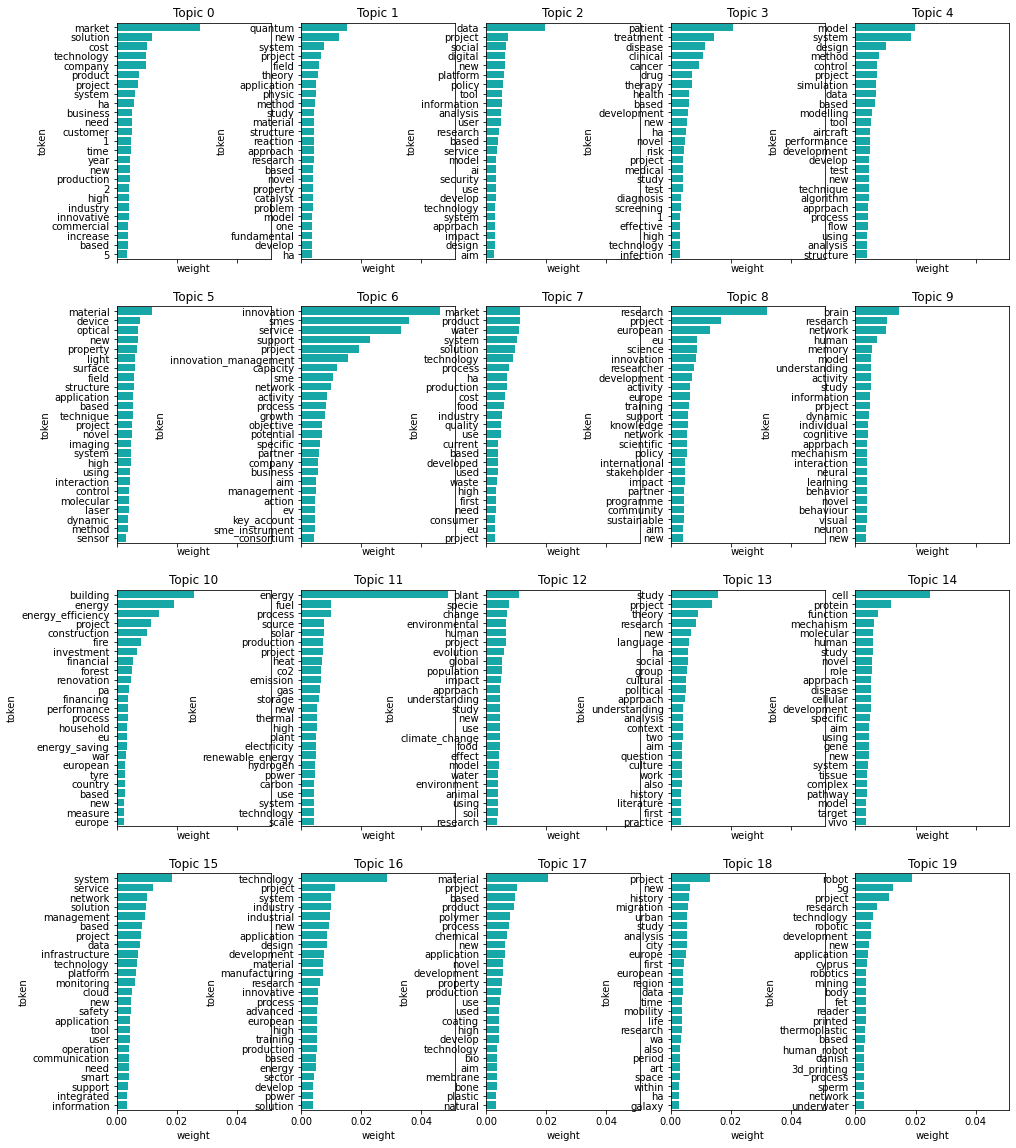

In [36]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):


    a = ldag.show_topic(i, topn=25)
    b = ldag.show_topic(i+5, topn=25)
    c = ldag.show_topic(i+10, topn=25)
    d = ldag.show_topic(i+15, topn=25)

    token_i = []
    weight_i = []
    token_i_4 = []
    weight_i_4 = []
    token_i_10 = []
    weight_i_10 = []
    token_i_15 = []
    weight_i_15 = []

    for j in range(topn):
        token_i.append(a[j][0])
        weight_i.append(a[j][1])
        token_i_4.append(b[j][0])
        weight_i_4.append(b[j][1])
        token_i_10.append(c[j][0])
        weight_i_10.append(c[j][1])
        token_i_15.append(d[j][0])
        weight_i_15.append(d[j][1])

    df = pd.DataFrame(data = (token_i,weight_i))
    df = df.T

    df.columns = ['token', 'weight']

    df['weight'] = df['weight'].astype('float64')

    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i
    #df = pd.DataFrame( ...
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    #<SOL>
    # Build a dataframe with columns 'token' and 'weight' for topic i + 4
    #df = pd.DataFrame( ...
    df = pd.DataFrame(data = (token_i_4,weight_i_4))
    df = df.T
    df.columns = ['token', 'weight']
    df['weight'] = df['weight'].astype('float64')
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))

    df = pd.DataFrame(data = (token_i_10,weight_i_10))
    df = df.T
    df.columns = ['token', 'weight']
    df['weight'] = df['weight'].astype('float64')
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))


    df = pd.DataFrame(data = (token_i_15,weight_i_15))
    df = df.T
    df.columns = ['token', 'weight']
    df['weight'] = df['weight'].astype('float64')
    #</SOL>
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i+15))

Generamos el corpus con representación lda dado el modelo creado

In [37]:
corpus_lda = ldag[text_bow]

In [38]:
len(corpus_lda)

35378

Veamos un ejemplo donde, el doc0 se representa como la representación probabilistica de similitud con cada uno de los topics

In [39]:
corpus_lda[0]

[(0, 0.032065842),
 (2, 0.046845768),
 (3, 0.5851588),
 (8, 0.07975601),
 (10, 0.015355607),
 (18, 0.23679501)]

In [41]:
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.7 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=4380f162c3717bc26b269565c70823b57ef874a14253082c566182363da614ee
  Stored in directory: /root/.cache/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis


In [43]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(ldag, text_bow, D)
pyLDAvis.display(vis_data)

# Clasificación de primer nivel

# Grafo